## Anomaly Detection in Electrocardiograms using LSTMs:

    * ECG data from http://www.cs.ucr.edu/~eamonn/discords/
    * Differencing implemented upto the first order trends. The data also seems to have long-range trends which could not be differenced out from the data.
    * 2 inputs and multi-output model
    * 2 LSTMs layers with accompanying batch normalization layers for each input
    * Tensorflow version: 2.0.0-beta1
    * Signal analysis using Empirical Mode Decomposition and Autocorrelation plots
    * Training with LSTMs shows good predictions and the ability to detect anomalies. With more data, the training can be improved to also model the higher order trends in the data.
    * For anomaly warning, a mean absolute/squared error metric between the real and predicted data can be defined with a certain threshold above which an anomaly warning can be sounded.

In [1]:
from IPython import get_ipython

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import tensorflow as tf
get_ipython().run_line_magic('matplotlib', 'inline')

In [4]:
print('Tensorflow verion: ', tf.__version__)

Tensorflow verion:  2.0.0-beta1


 ### Importing ecg data

In [5]:
ecg_data =  pd.read_csv('chfdb_chf01_275.txt', sep = '\t', header = None)

In [6]:
ecg_data.head(10)

,0,1,2
0,275.000,-0.645,0.665
1,275.004,-0.635,0.710
2,275.008,-0.645,0.745
3,275.012,-0.635,0.760
4,275.016,-0.645,0.785
5,275.020,-0.630,0.790
6,275.024,-0.630,0.815
7,275.028,-0.635,0.835
8,275.032,-0.625,0.860
9,275.036,-0.645,0.870


In [7]:
ecg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Data columns (total 3 columns):
0    3751 non-null float64
1    3751 non-null float64
2    3751 non-null float64
dtypes: float64(3)
memory usage: 88.0 KB


 #### Plotting

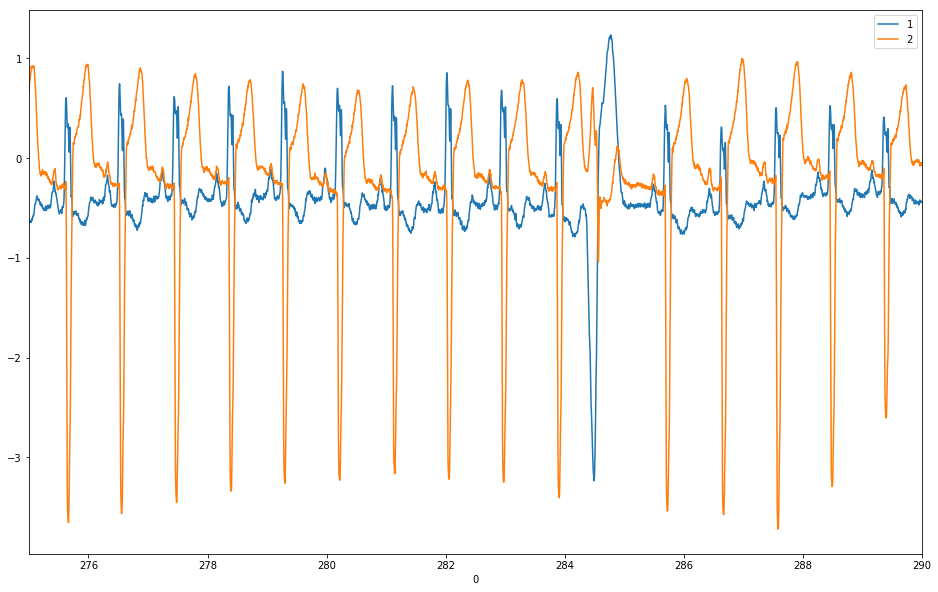

In [8]:
ecg_data[:].plot(x = 0, y = [1,2], figsize = (16, 10))

 ### Signal Analysis of data
 * Choosing data just before the anomaly

In [9]:
train_data = ecg_data[ecg_data[0] <= 284]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2251 entries, 0 to 2250
Data columns (total 3 columns):
0    2251 non-null float64
1    2251 non-null float64
2    2251 non-null float64
dtypes: float64(3)
memory usage: 70.3 KB


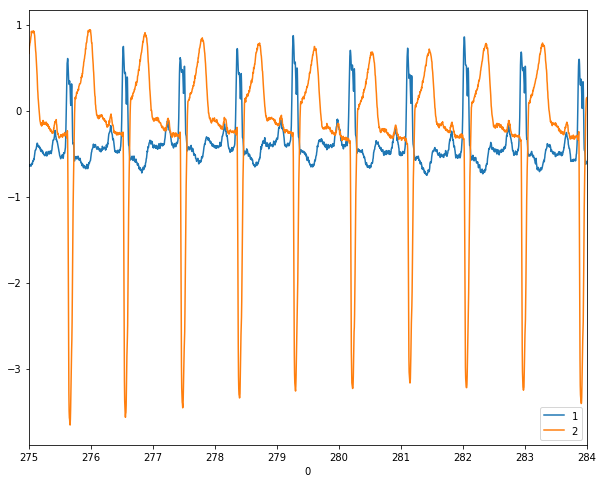

In [10]:
train_data[:].plot(x = 0, y = [1,2], figsize = (10,8))

 #### Signal Analysis using Empirical Mode Decomposition

In [11]:
from PyEMD import EMD

In [12]:
emd = EMD(nbsym=5)

         * nbsymb argument of the EMD function is a control parameter for tuning the IMFs

In [13]:
IMF = emd.emd(S = train_data[1].values, T = train_data[0].values, max_imf=10)
# IMF:Intrinsic Mode Functions

N = IMF.shape[0] + 1
print("Number of decompositions: %d" %N)

Number of decompositions: 10


 #### Plotting

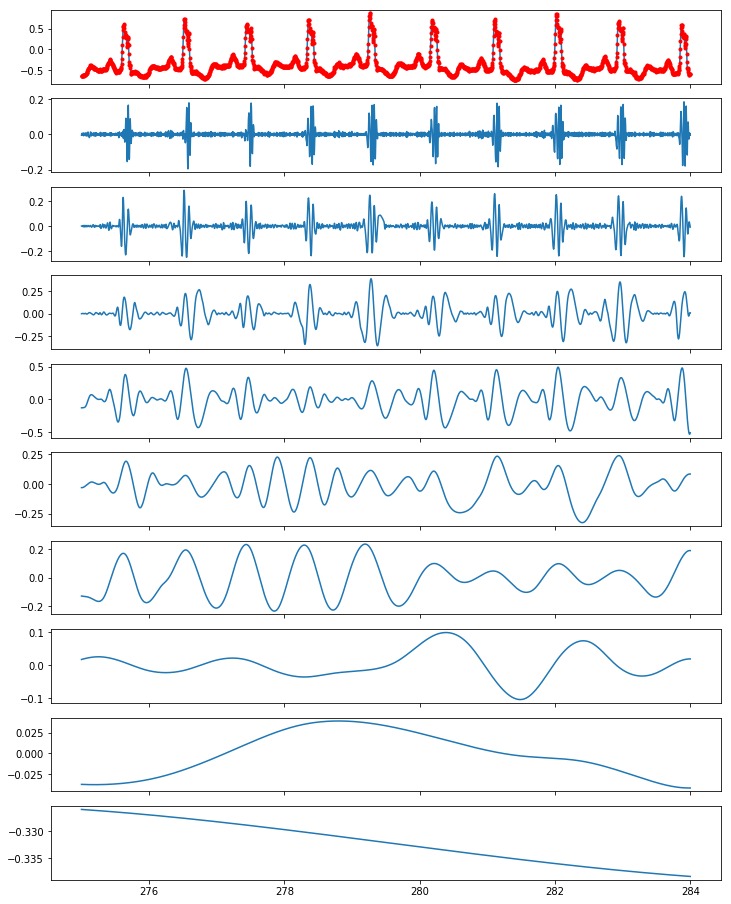

In [14]:
fig1, ax1 = plt.subplots(N, 1, sharex=True, figsize = (12, 16))

ax1[0].plot(train_data[0], train_data[1])
ax1[0].plot(train_data[0], np.sum(IMF, axis=0), 'r.')


for enum, imf in enumerate(IMF,1):
    ax1[enum].plot(train_data[0], imf)

 ### Signal Analysis using Correlation Plots

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

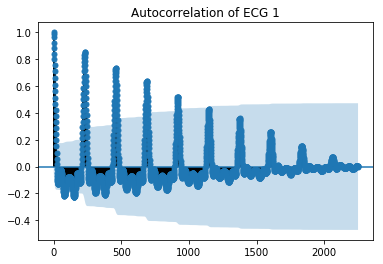

In [16]:
plot_acf(train_data[1],lags=len(train_data)-1)
plt.title('Autocorrelation of ECG 1')
plt.show()

 #### Autocorrelation plot of the 1st decomposed mode

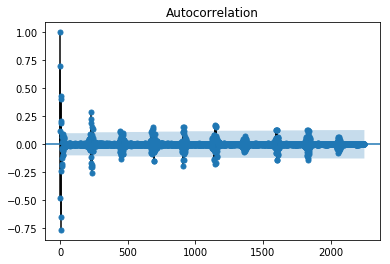

In [17]:
plot_acf(IMF[0], fft=True, lags=IMF.shape[1]-1)
plt.show()

In [18]:
# Importing autocorrelation function
from statsmodels.tsa.stattools import acf

In [19]:
# acf on train data with fft = False
train_data_acf = acf(train_data[1], fft = False, nlags=len(train_data)-1)
train_data_acf.shape

(2251,)

In [20]:
# Obtaining the locations of the peak maxima
arg_max_val = scp.signal.argrelextrema(train_data_acf, np.greater, order = 200)
arg_max_val

(array([ 229,  459,  688,  916, 1146, 1375, 1604, 1835, 2062]),)

In [21]:
# Differencing to extract the periodic values
np.diff(arg_max_val)

array([[230, 229, 228, 230, 229, 229, 231, 227]])

In [22]:
# Repeating the above on the first IMF mode
imf_0_acf = acf(IMF[0], nlags=IMF.shape[1]-1)
imf_0_acf.shape

/home/sameer/datascience/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(2251,)

In [23]:
arg_max_val_imf = scp.signal.argrelextrema(imf_0_acf, np.greater, order = 200)
arg_max_val_imf

(array([ 231,  447,  690,  916, 1146, 1365, 1599, 1829, 2062]),)

In [24]:
# Differencing to extract the periodic values
np.diff(arg_max_val_imf)

array([[216, 243, 226, 230, 219, 234, 230, 233]])

In [25]:
# Repeating the same for the 2nd IMF mode
imf_1_acf = acf(IMF[1], nlags=IMF.shape[1]-1)
np.diff(scp.signal.argrelextrema(imf_1_acf, np.greater, order = 150))

array([[230, 229, 229, 229, 229, 230, 206, 252]])

In [26]:
print('From IMF[0], mean = {0:.3f} and std = {1:.3f}'.format(np.mean(np.diff(arg_max_val_imf)), np.std(np.diff(arg_max_val_imf))))

From IMF[0], mean = 228.875 and std = 8.038


In [27]:
print('From train_data, mean = {0:.3f} and std = {1:.3f}'.format(np.mean(np.diff(arg_max_val)), np.std(np.diff(arg_max_val))))

From train_data, mean = 229.125 and std = 1.166


In [28]:
print('Therefore, the first order periodicity in the data is %d' %np.mean(np.diff(arg_max_val)))

Therefore, the first order periodicity in the data is 229


 ### Differencing by
 #### 1) deriving the average values of each time point upto the periodicity and then 2) subtracting from the dataset

In [29]:
# Using the periodicity obtained from acf of training data
periodicity = np.round(np.mean(np.diff(arg_max_val))).astype('int')
periodicity

229

In [30]:
def differencing_values(data, cols, period):
    """ data: Dataframe format
        cols = list of columns on which the averaging needs to be carried out"""
    
    splits = len(data)//period
    
    values = np.zeros(shape=(period, len(cols)), dtype='float32')
    
    for i in range(splits):
        values = values + data.iloc[i*period:(i+1)*period, cols].values
    
    return values/splits


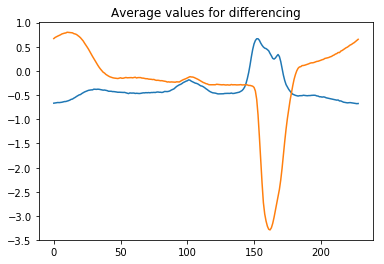

In [31]:
# Average values for differencing
trend_values = differencing_values(train_data, [1,2], periodicity)
plt.plot(trend_values)
plt.title("Average values for differencing")
plt.show()

In [32]:
# Setting the precision of numpy arrays during printing
np.set_printoptions(precision=3)

 #### Differencing Function

In [33]:
def differencing_fn(values, periodicity):
    
    n_size = values.shape[0]   
    index = 0    
    splits = 1
    
    for i in range(n_size):
        values[i,:] = values[i,:] - trend_values[index, :]
        index += 1
        if index == periodicity:
            print(index, splits)
            splits+=1
            index = 0
            
    return values

229 1
229 2
229 3
229 4
229 5
229 6
229 7
229 8
229 9
229 10
229 11
229 12
229 13
229 14
229 15
229 16


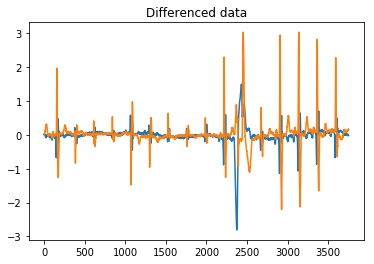

In [34]:
diff_data = differencing_fn(ecg_data[[1,2]].values, periodicity=periodicity)
plt.plot(diff_data)
plt.title("Differenced data")
plt.show()

     * Using this differencing for ML

 ### Establishing training and test data

In [35]:
# Standardizing data
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()
scaled_data =  scaler.fit_transform(diff_data)
scaled_data.shape

(3751, 2)

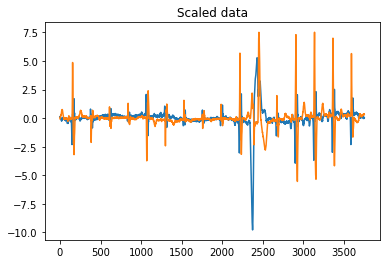

In [37]:
plt.plot(scaled_data)
plt.title("Scaled data")
plt.show()

 ##### Converting dtype

In [38]:
if scaled_data.dtype != 'float32':
    scaled_data = scaled_data.astype('float32')
scaled_data.dtype

dtype('float32')

 ### Multi-Input, Multi-Step Multi-Output

     * In this case, 2 inputs, and 2 outputs with multiple time steps to predict.

 #### Using TimeSeriesGenerator for generating sequences

In [39]:
from tensorflow import keras

     * length, start_index and end_index are parameters for controlling the range

In [40]:
def sequencing_fn(input_data, seq_len=200, outputs = 1, reverse = False):
    """ reverse: True if the chronological order needs to be reversed"""
    
 
    temp = input_data
    n_size = len(input_data)
    
    if seq_len + outputs >= n_size:
        raise Exception("Sum of Number of time steps and Number of outputs to forecast must be smaller than the length of the input data")
    
    x_gen = keras.preprocessing.sequence.TimeseriesGenerator(temp, temp, length=seq_len, end_index=n_size-outputs-1, batch_size=len(temp), reverse=False)
    
    y_gen = keras.preprocessing.sequence.TimeseriesGenerator(temp, temp, length=outputs, start_index=seq_len, batch_size=len(temp), reverse=False)
    
    x = np.expand_dims(x_gen[0][0], axis=-1)
    y = y_gen[0][0]

    print("X shape: %s, Y shape: %s" %(x.shape, y.shape))
    
    return tf.data.Dataset.from_tensor_slices(({'ecg_1': x[:,:,0], 'ecg_2': x[:,:,1]}, 
           {'ecg_1_output': y[:,:,0], 'ecg_2_output': y[:,:,1]}))

 #### Preparing Datasets

In [41]:
# Setting the number of timesteps for training and number of outputs to predict
n_timesteps=229
n_outputs = 10

In [42]:
train_dataset = sequencing_fn(scaled_data[:1700], n_timesteps, n_outputs)
validation_dataset = sequencing_fn(scaled_data[1700:2000], n_timesteps, n_outputs)
test_dataset = sequencing_fn(scaled_data[2000:], n_timesteps, n_outputs)

X shape: (1461, 229, 2, 1), Y shape: (1461, 10, 2)
X shape: (61, 229, 2, 1), Y shape: (61, 10, 2)
X shape: (1512, 229, 2, 1), Y shape: (1512, 10, 2)


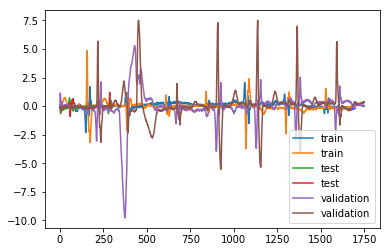

In [43]:
plt.plot(scaled_data[:1700], label = 'train')
plt.plot(scaled_data[1700:2000], label = 'test')
plt.plot(scaled_data[2000:], label = 'validation')
plt.legend(loc='best')
plt.show()

In [44]:
# Batch size for training
batch_size = 16

In [45]:
train_dataset = train_dataset.batch(batch_size, drop_remainder = True)
validation_dataset = validation_dataset.batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [46]:
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

 ### LSTM Model

In [47]:
def new_model(batch_size=1, training = True, lstm1 = 128, lstm2 = 64, batchnorm1 = True, batchnorm2=True, dropout = 0.3, recurrent_dropout = 0.3, n_outputs = 1):
    input_1 = keras.Input(shape = (None,1), batch_size=batch_size, name = 'ecg_1', dtype=tf.float32)
    input_2 = keras.Input(shape = (None,1), batch_size=batch_size, name = 'ecg_2', dtype=tf.float32)
    
    lstm_ecg1_1 = keras.layers.LSTM(units = lstm1, return_sequences=True, stateful = False, name = 'lstm_1_ecg_1')(input_1, training = training)
    lstm_ecg2_1 = keras.layers.LSTM(units = lstm1, return_sequences=True, stateful = False, name = 'lstm_1_ecg_2')(input_2, training = training)
    
    if batchnorm1==True:
        lstm_ecg1_1 = keras.layers.BatchNormalization(renorm=False)(lstm_ecg1_1)
        lstm_ecg2_1 = keras.layers.BatchNormalization(renorm=False)(lstm_ecg2_1)
    
    lstm_ecg1_2 = keras.layers.LSTM(units = lstm2, dropout=dropout, recurrent_dropout=recurrent_dropout, 
                           stateful = False, name = 'lstm_2_ecg_1')(lstm_ecg1_1, training = training)
    lstm_ecg2_2 = keras.layers.LSTM(units = lstm2, dropout=dropout, recurrent_dropout=recurrent_dropout, 
                           stateful = False, name = 'lstm_2_ecg_2')(lstm_ecg2_1, training = training)
                    
    if batchnorm2==True:
        lstm_ecg1_2 = keras.layers.BatchNormalization(renorm=False)(lstm_ecg1_2)
        lstm_ecg2_2 = keras.layers.BatchNormalization(renorm=False)(lstm_ecg2_2)
    
    merged_features = keras.layers.concatenate([lstm_ecg1_2, lstm_ecg2_2])
    
    output_1 = keras.layers.Dense(units = n_outputs, name = 'ecg_1_output')(merged_features)
    output_2 = keras.layers.Dense(units = n_outputs, name = 'ecg_2_output')(merged_features)
    
    model = keras.Model(inputs = [input_1, input_2], outputs = [output_1, output_2], name = 'ecg_model_1')
    
    return model    



In [48]:
keras.backend.clear_session()

In [49]:
# Creating a new model for training
model = new_model(batch_size=batch_size, lstm1 = 128, lstm2 = 64, batchnorm1=True, batchnorm2=True, n_outputs=10, training=True)

In [50]:
model.summary()

Model: "ecg_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ecg_1 (InputLayer)              [(16, None, 1)]      0                                            
__________________________________________________________________________________________________
ecg_2 (InputLayer)              [(16, None, 1)]      0                                            
__________________________________________________________________________________________________
lstm_1_ecg_1 (LSTM)             (16, None, 128)      66560       ecg_1[0][0]                      
__________________________________________________________________________________________________
lstm_1_ecg_2 (LSTM)             (16, None, 128)      66560       ecg_2[0][0]                      
________________________________________________________________________________________

In [51]:
from IPython.display import SVG

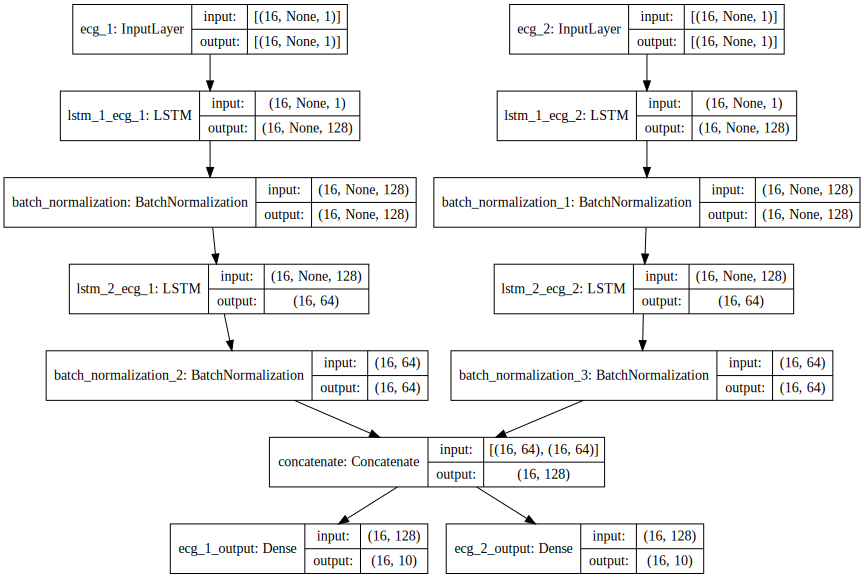

In [52]:
# Model to dot representation
model_display = keras.utils.model_to_dot(model, show_shapes=True, dpi=72)
SVG(model_display.create(prog = 'dot', format='svg'))

 #### Callbacks

In [53]:
cb_list = []

 ##### Early Stopping CallBack

In [54]:
cb_early_stopping = keras.callbacks.EarlyStopping(monitor = 'loss', min_delta=1e-4, patience = 3)
cb_list.append(cb_early_stopping)

 ##### Saving Model CallBack

In [55]:
savedmodel_pathname = 'saved_models'
if os.path.exists(savedmodel_pathname):
    pass
else:
    os.mkdir(savedmodel_pathname)

    
cb_model_chkpt = keras.callbacks.ModelCheckpoint(filepath=savedmodel_pathname  + '/' + 'model_{epoch}-{val_loss:.3f}.h5', monitor = 'val_loss', verbose = 1, 
                                           save_best_only=True)
cb_list.append(cb_model_chkpt)


 ##### Dynamic Learning Rate CallBack

         * Static Learning Rate can be set using keras.optimizers.schedules api

In [56]:
cb_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose = 1, patience = 2)
cb_list.append(cb_lr)

 ##### TensorBoard

In [57]:
tensorboard_pathname = 'logs'
if os.path.exists(tensorboard_pathname):
    pass
else:
    os.mkdir(tensorboard_pathname)

cb_tensorboard = keras.callbacks.TensorBoard(log_dir = tensorboard_pathname, histogram_freq=1)
cb_list.append(cb_tensorboard)

In [58]:
print(cb_list)

[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7ff9a06300f0>, <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7ff9a05b1be0>, <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7ff9a05b1978>, <tensorflow.python.keras.callbacks.TensorBoard object at 0x7ff9a05b1c88>]


 #### Model Compiling

In [59]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss={'ecg_1_output': 'mse', 'ecg_2_output': 'mse'},
             metrics = {'ecg_1_output': 'mse', 'ecg_2_output': 'mse'})

 #### Model Fitting

In [60]:
initial_epoch = 0
epochs = 10

In [61]:
history = model.fit(train_dataset, epochs = epochs, verbose = 1, callbacks=cb_list, validation_data=validation_dataset, 
                    shuffle=False, initial_epoch=initial_epoch)

Epoch 1/10
 1/91 [..............................] - ETA: 10:01 - loss: 3.4338 - ecg_1_output_loss: 1.5821 - ecg_2_output_loss: 1.8518 - ecg_1_output_mse: 1.5821 - ecg_2_output_mse: 1.8518

W1008 18:47:39.737129 140712632162112 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (3.845345). Check your callbacks.


90/91 [============================>.] - ETA: 0s - loss: 0.8317 - ecg_1_output_loss: 0.3569 - ecg_2_output_loss: 0.4748 - ecg_1_output_mse: 0.3569 - ecg_2_output_mse: 0.4748
Epoch 00001: val_loss improved from inf to 0.16720, saving model to saved_models/model_1-0.167.h5
91/91 [==============================] - 36s 391ms/step - loss: 0.8235 - ecg_1_output_loss: 0.3534 - ecg_2_output_loss: 0.4701 - ecg_1_output_mse: 0.3534 - ecg_2_output_mse: 0.4701 - val_loss: 0.1672 - val_ecg_1_output_loss: 0.0604 - val_ecg_2_output_loss: 0.1068 - val_ecg_1_output_mse: 0.0604 - val_ecg_2_output_mse: 0.1068
Epoch 2/10
90/91 [============================>.] - ETA: 0s - loss: 0.2982 - ecg_1_output_loss: 0.0820 - ecg_2_output_loss: 0.2161 - ecg_1_output_mse: 0.0820 - ecg_2_output_mse: 0.2161
Epoch 00002: val_loss did not improve from 0.16720
91/91 [==============================] - 18s 199ms/step - loss: 0.2955 - ecg_1_output_loss: 0.0814 - ecg_2_output_loss: 0.2141 - ecg_1_output_mse: 0.0814 - ecg_2_outp

 ##### testing on test datast

In [62]:
model.evaluate(test_dataset)

94/94 [==============================] - 7s 71ms/step - loss: 5.6521 - ecg_1_output_loss: 3.2621 - ecg_2_output_loss: 2.3900 - ecg_1_output_mse: 3.2621 - ecg_2_output_mse: 2.3900


[5.652098330015198, 3.262086, 2.390013, 3.262086, 2.390013]

In [63]:
del model   

 ### Anomaly Detection

In [64]:
def pred_fn(input_data, model_params = [128, 64, True, True], filepath = 'folder/h5 file', num_of_predictions = 1):
    """
    Function for predicting given input features
    Input shape: n x 2,
             type: array,
    Input dtype must match the dtype of the input layer of the network
    batch_size = 1
    filepath =  path to the saved model
    num_of_predictions = number of predictions    

    returns array with predicted output added to the input
    """    
    
    input_data = tf.expand_dims(input_data, axis=0)
    input_data = tf.expand_dims(input_data, axis=-1)
    
    input_1 = input_data[:,:,0]
    input_2 = input_data[:,:,1]
    
    keras.backend.clear_session()
    # for decluttering

    model = new_model(batch_size=1, lstm1=model_params[0], lstm2 = model_params[1], batchnorm1 = model_params[2],batchnorm2=model_params[3], training=False, n_outputs=10)
    model.load_weights(filepath)
    model.reset_states()
    
    for i in range(num_of_predictions):
        output_1, output_2 = model([input_1, input_2])
        
        input_1 = tf.concat([input_1, tf.expand_dims(output_1, axis=-1)], axis=1)
        input_2 = tf.concat([input_2, tf.expand_dims(output_1, axis=-1)], axis=1)
        
       
    del model
    
    return np.vstack((np.ravel(input_1), np.ravel(input_2))).T

In [65]:
def plot_test_fn(start_index=0, end_index = periodicity, model_params = [128, 64, True, True], filepath= 'folder/h5 file', num_of_predictions = 1):

    """
    Function plotting real and predicted data
    Calls the pred_fn

    start_index/end_index: range of input data
    It is important the test data be indexed properly with respect to t=0 so that the trend values are added correctly to the predicted data.

    filepath: path to the saved model

    num_of_predictions: number of predictions



    """
    
    test_data = scaled_data[start_index:end_index]
    # input data for prediction

    predicted_data = pred_fn(test_data, model_params = model_params, filepath=filepath, num_of_predictions=num_of_predictions)    
    
    predicted_data = scaler.inverse_transform(predicted_data)
    # transforming back to the original format

    test_data = scaled_data[start_index:end_index+num_of_predictions*n_outputs]
    # including the data to be compared with the predicted output
    
    test_data = scaler.inverse_transform(test_data)
    # transforming back to the original format

    assert len(predicted_data) == len(test_data)

    
    # Adding the trend values to the data
    
    strt_val = start_index%periodicity
    # gives the starting index in the trend data

    for i in range(len(predicted_data)):
        if strt_val == periodicity:
            strt_val = 0
            predicted_data[i] = predicted_data[i] + trend_values[strt_val]
            test_data[i] = test_data[i] + trend_values[strt_val]
            strt_val +=1
        else:
            predicted_data[i] = predicted_data[i] + trend_values[strt_val]
            test_data[i] = test_data[i] + trend_values[strt_val]
            strt_val +=1
    
    plt.plot(test_data[:,0], 'b', label = 'ecg1 sensor')
    plt.plot(test_data[:,1], 'r', label = 'ecg2 sensor')
    plt.plot(predicted_data[:,0], 'b--', label = 'ecg1 sensor prediction')
    plt.plot(predicted_data[:,1], 'r--', label = 'ecg2 sensor prediction')
    plt.legend(loc='best')
    plt.show()



### A simple prediction function using the differenced values used to remove the trend of the 1st order

In [66]:
def simple_pred_fn(start_index=0, end_index = periodicity, num_of_predictions = 1):

    """
    Function plotting real and predicted data
    
    Data is predicted using the index of the data from which the subsequent values are predicted from the trend values

    start_index/end_index: range of input data
    It is important the test data be indexed properly with respect to t=0 so that the trend values are added correctly to the predicted data.

    num_of_predictions: number of time points to predict

    

    """
    
    predicted_data = scaled_data[start_index:end_index]    
    
    predicted_data = scaler.inverse_transform(predicted_data)
    # transforming back to the original format

    test_data = scaled_data[start_index:end_index+num_of_predictions]
    # including the data to be compared with the predicted output
    
    test_data = scaler.inverse_transform(test_data)
    # transforming back to the original format

    predicted_data = np.vstack((predicted_data, np.zeros((num_of_predictions, test_data.shape[1]), dtype=np.float32)))
    # assert len(predicted_data) == len(test_data)

    
    # Adding the trend values to the data
    
    strt_val = start_index%periodicity
    # gives the starting index in the trend data

    for i in range(len(test_data)):
        if strt_val == periodicity:
            strt_val = 0
            test_data[i] = test_data[i] + trend_values[strt_val]

            predicted_data[i] = predicted_data[i] + trend_values[strt_val]
            strt_val +=1
        else:
            predicted_data[i] = predicted_data[i] + trend_values[strt_val]
            test_data[i] = test_data[i] + trend_values[strt_val]
            strt_val +=1
    
    plt.plot(test_data[:,0], 'b', label = 'ecg1 sensor')
    plt.plot(test_data[:,1], 'r', label = 'ecg2 sensor')
    plt.plot(predicted_data[:,0], 'b--', label = 'ecg1 sensor prediction')
    plt.plot(predicted_data[:,1], 'r--', label = 'ecg2 sensor prediction')
    plt.legend(loc='best')
    plt.show()

 ### Testing on data

        * Using the best models for prediction

 #### Train data

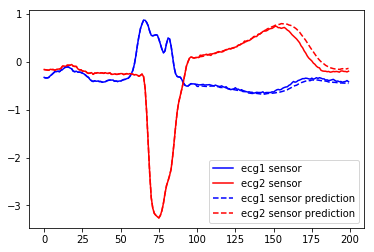

In [67]:
simple_pred_fn(start_index=1000, end_index=1100, num_of_predictions=100)

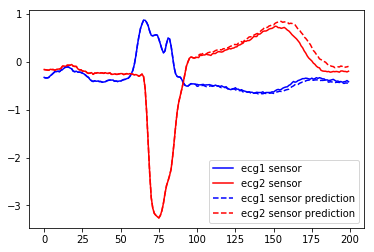

In [68]:
plot_test_fn(start_index = 1000, end_index=1100, model_params=[128,64, True, True],filepath='saved_models/model_9-0.051.h5', num_of_predictions=10)

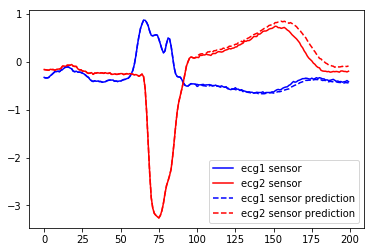

In [69]:
plot_test_fn(start_index = 1000, end_index=1100, model_params=[128,64, False, True],filepath='saved_models/model_1-0.049.h5', num_of_predictions=10)

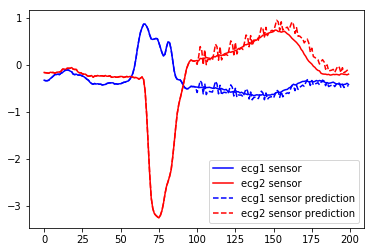

In [70]:
plot_test_fn(start_index = 1000, end_index=1100, model_params=[512,256, True, True],filepath='saved_models/model_8-0.063.h5', num_of_predictions=10)

 #### Validation data

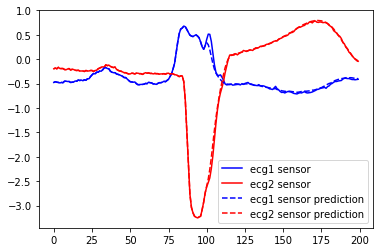

In [71]:
simple_pred_fn(start_index=1900, end_index=2000, num_of_predictions=100)

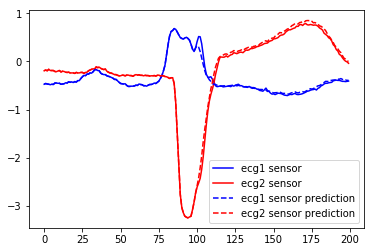

In [72]:
plot_test_fn(start_index = 1900, end_index=2000, model_params=[128,64, True, True],filepath='saved_models/model_9-0.051.h5', num_of_predictions=10)

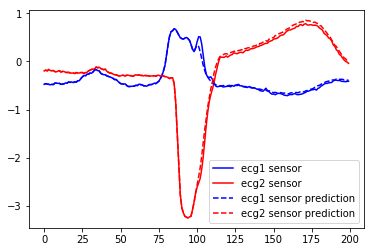

In [73]:
plot_test_fn(start_index = 1900, end_index=2000, model_params=[128,64, False, True],filepath='saved_models/model_1-0.049.h5', num_of_predictions=10)

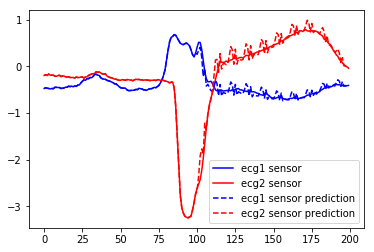

In [74]:
plot_test_fn(start_index = 1900, end_index=2000, model_params=[512,256, True, True],filepath='saved_models/model_8-0.063.h5', num_of_predictions=10)

 #### Test data - No anomaly

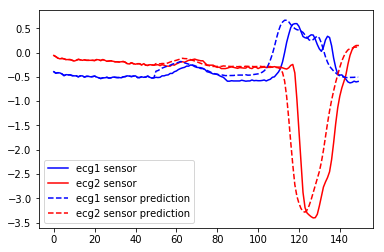

In [75]:
simple_pred_fn(start_index=2100, end_index=2150, num_of_predictions=100)

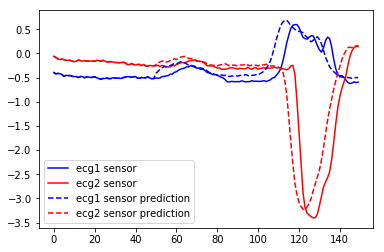

In [76]:
plot_test_fn(start_index = 2100, end_index=2150, model_params=[128,64, True, True],filepath='saved_models/model_9-0.051.h5', num_of_predictions=10)

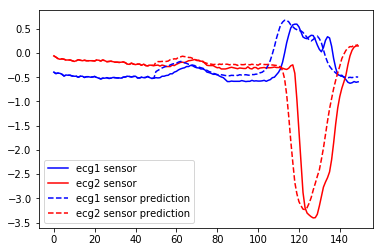

In [77]:
plot_test_fn(start_index = 2100, end_index=2150, model_params=[128,64, False, True],filepath='saved_models/model_1-0.049.h5', num_of_predictions=10)

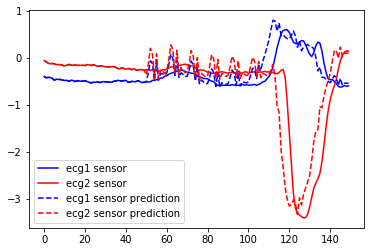

In [78]:
plot_test_fn(start_index = 2100, end_index=2150, model_params=[512,256, True, True],filepath='saved_models/model_8-0.063.h5', num_of_predictions=10)

 #### Test data - Anomaly

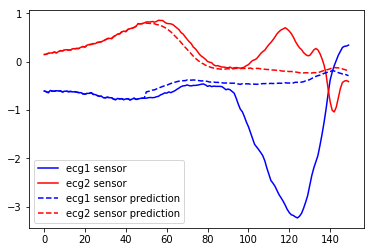

In [79]:
simple_pred_fn(start_index=2250, end_index=2300, num_of_predictions=100)

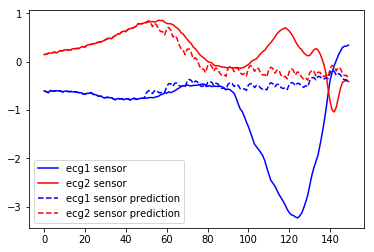

In [80]:
plot_test_fn(start_index = 2250, end_index=2300, model_params=[128,64, True, True],filepath='saved_models/model_1-0.077.h5', num_of_predictions=10)

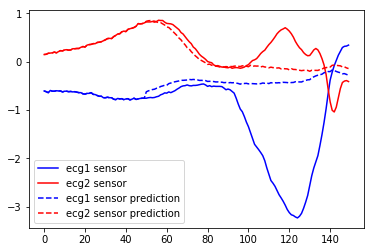

In [81]:
plot_test_fn(start_index = 2250, end_index=2300, model_params=[128,64, False, True],filepath='saved_models/model_1-0.049.h5', num_of_predictions=10)

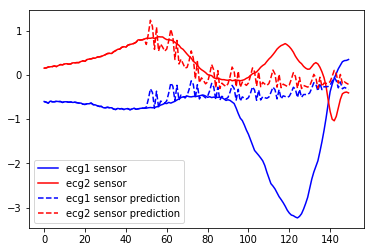

In [82]:
plot_test_fn(start_index = 2250, end_index=2300, model_params=[512,256, True, True],filepath='saved_models/model_8-0.063.h5', num_of_predictions=10)

       * In this case the simple function suffices in predicting an anomaly. Training with LSTMs shows good predictions and the ability to detect anomalies. With more data, the training can be improved to also model the higher order trends in the data.
       * For anomaly warning, a mean absolute/squared error metric between the real and predicted data can be defined with a certain threshold above which an anomaly warning can be sounded.